## Propensity Score Estimation and (IPW based) Causal Treatment Effect Estimation 

In [1]:
# install package for data access, may skip if already installed
# install.packages("Matching")

## Dataset

The Lalonde datasets are widely used in the causal inference literature.  The NSW Demonstration was a federally and privately funded program implemented in the mid-1970s to provide work experience for a period of 6-18 months (treatment) to individuals who had faced economic and social problems prior to enrollment in the program. Both the treatment and control groups participated in follow-up interviews at specific intervals. Lalonde offered a separate analysis of the male and female participants in his 1986 paper

**Robert Lalonde (1986), "Evaluating the Econometric Evaluations of Training Programs," American Economic Review, Vol. 76, pp. 604-620**

The dataset employed here is further filtered by Dehejia-Wahha, which is a subset of Lalonde's NSW experimental data, which is a male only subset with complete information on earnings in 1974 (RE74) as a pre-intervention variable.

**Dehejia, Rajeev H., and Sadek Wahba (1999) "Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs," Journal of the American Statistical Association, Vol. 94, No. 448, pp. 1053-1062**

In [1]:
# loading packages
require(Matching)
data(lalonde)
head(lalonde)

Loading required package: Matching
Loading required package: MASS
## 
##  Matching (Version 4.9-2, Build Date: 2015-12-25)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##



age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
37,11,1,0,1,1,0,0,9930.05,1,1,1
22,9,0,1,0,1,0,0,3595.89,1,1,1
30,12,1,0,0,0,0,0,24909.50,1,1,1
27,11,1,0,0,1,0,0,7506.15,1,1,1
33,8,1,0,0,1,0,0,289.79,1,1,1
22,9,1,0,0,1,0,0,4056.49,1,1,1


The outcome is re78 – post-intervention income.

The treatment is treat – which is equal to 1 if the subject received the labor training and equal to 0 otherwise.

The potential confounding variables are: age, educ, black, hispanic, married, nodegree, re74, re75.

#### Comparison of the distribution for all of the confounding variables between the two treatment groups

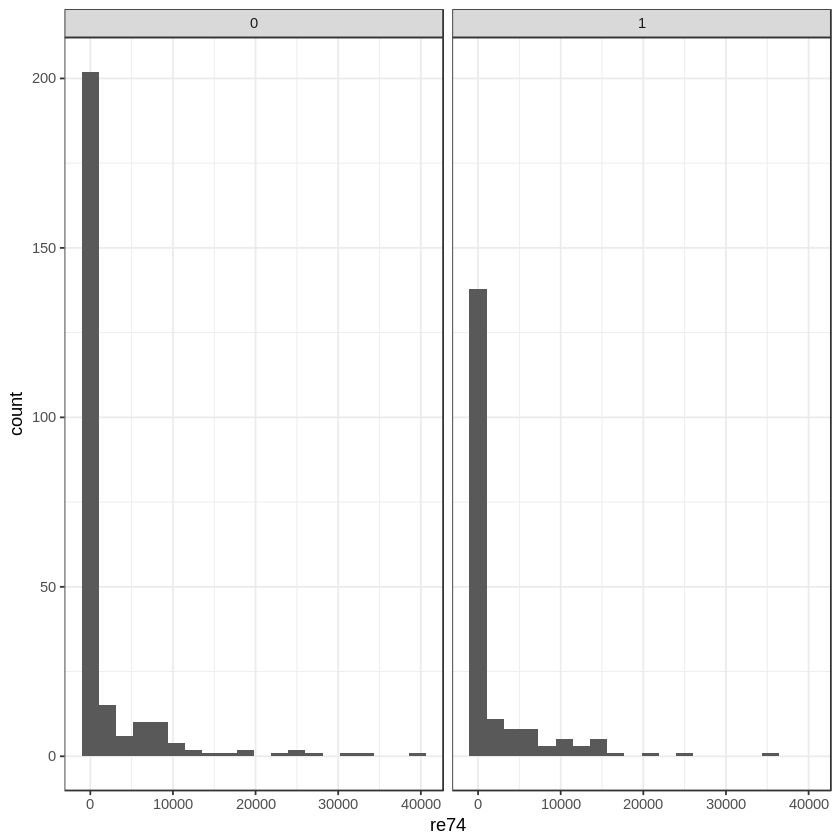

In [4]:
library(ggplot2)
ggplot(data=lalonde,aes(x=re74))+geom_histogram(bins = 20)+facet_grid(~treat)+theme_bw()

**unadjusted treatment effect**

raw difference between the mean of real earnings in 1978 for treated subjects and the mean of real earnings in 1978 for untreated subjects

In [51]:
mean(lalonde[lalonde$treat==1,]$re78) - mean(lalonde[lalonde$treat==0,]$re78)

[1] 1794.343

#### Propensity Score Estimation

Fit a propensity score model, where the outcome is treatment. Include the 8 confounding variables in the model as predictors. logistic regression is employed here with no interaction terms or non-linear terms (such as squared terms). 

In [2]:
fit <- glm(treat ~ age + educ + black + hisp + married + nodegr + re74 + re75,
           data=lalonde, family = binomial(link = "logit"))
prop_hat <- predict(fit, newdata = lalonde, type="response")
lalonde$pscore <- prop_hat
range(prop_hat);

[1] 0.1948270 0.6755609

###  Check Overlap of Propensity Scores

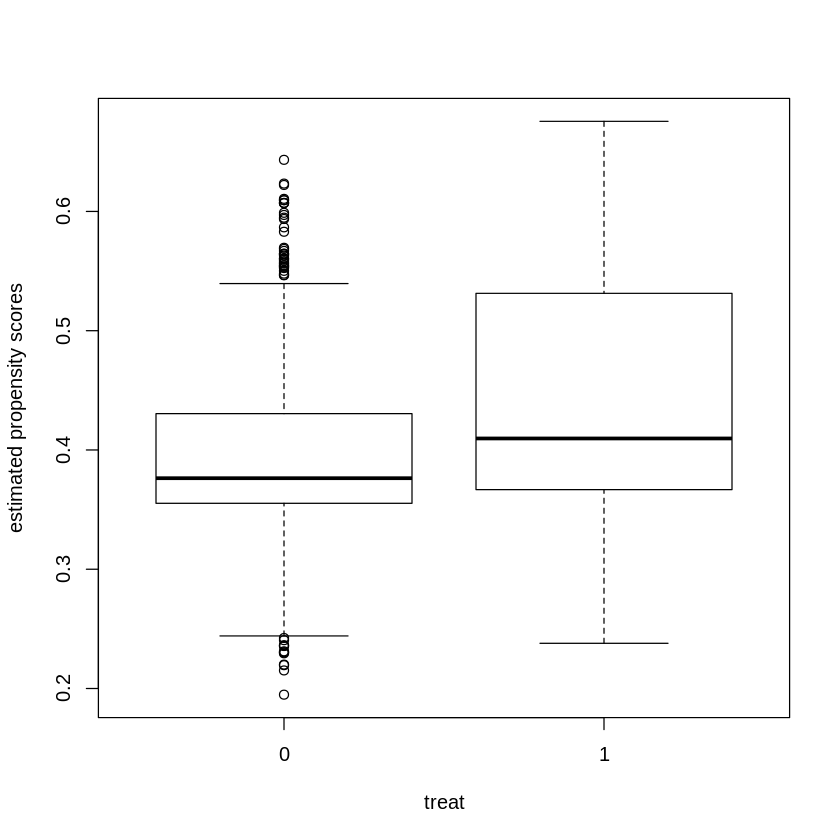

In [53]:
boxplot(split(lalonde$pscore, lalonde$treat), xlab="treat",
      ylab="estimated propensity scores")

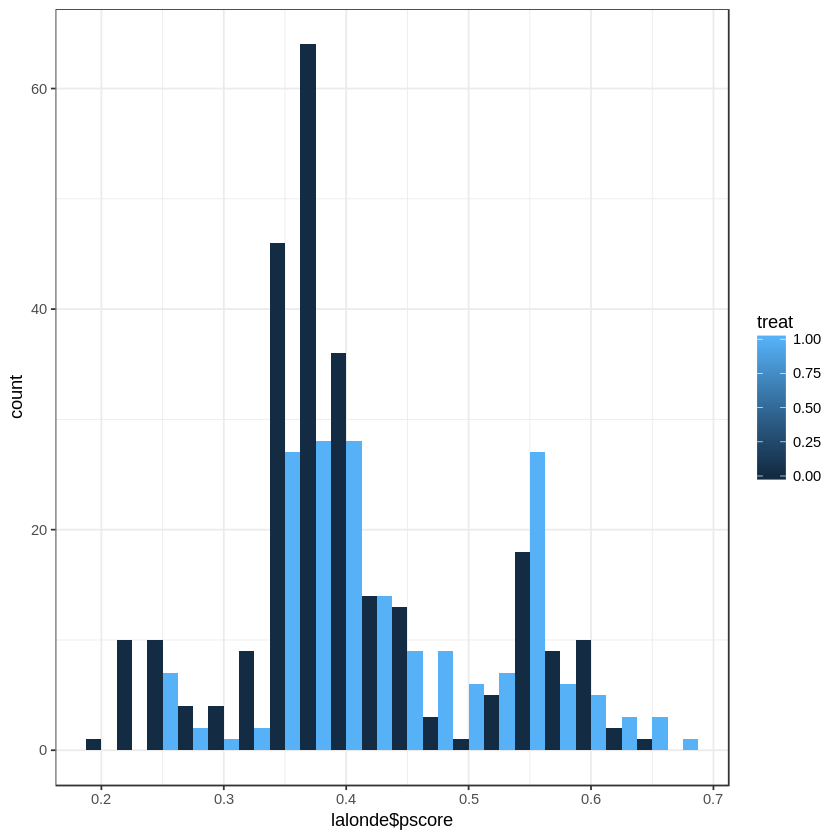

In [7]:
library(ggplot2)
g1 = ggplot(lalonde, aes(x=lalonde$pscore, group=treat, fill=treat)) + 
    geom_histogram(position="dodge",binwidth=0.025) + theme_bw()
g1

### Inverse Probability of Treatment Weighting (IPTW)

In [3]:
#Calculate Weights
library(survey)
lalonde$ipw.ate <- ifelse(lalonde$treat==1, 1/lalonde$pscore, 1/(1-lalonde$pscore))
#ATE Outcome Analysis
design.ate <- svydesign(ids= ~1, weights= ~ipw.ate, dat=lalonde)
mod.ipw.ate <- svyglm(re78 ~ treat, design=design.ate)
summary(mod.ipw.ate)

Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart




Call:
svyglm(formula = re78 ~ treat, design = design.ate)

Survey design:
svydesign(ids = ~1, weights = ~ipw.ate, dat = lalonde)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4549.8      343.2  13.257   <2e-16 ***
treat         1641.3      686.3   2.392   0.0172 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 45934134)

Number of Fisher Scoring iterations: 2


#### Comparison of the distribution for covariates between the two treatment groups in the weighted sample

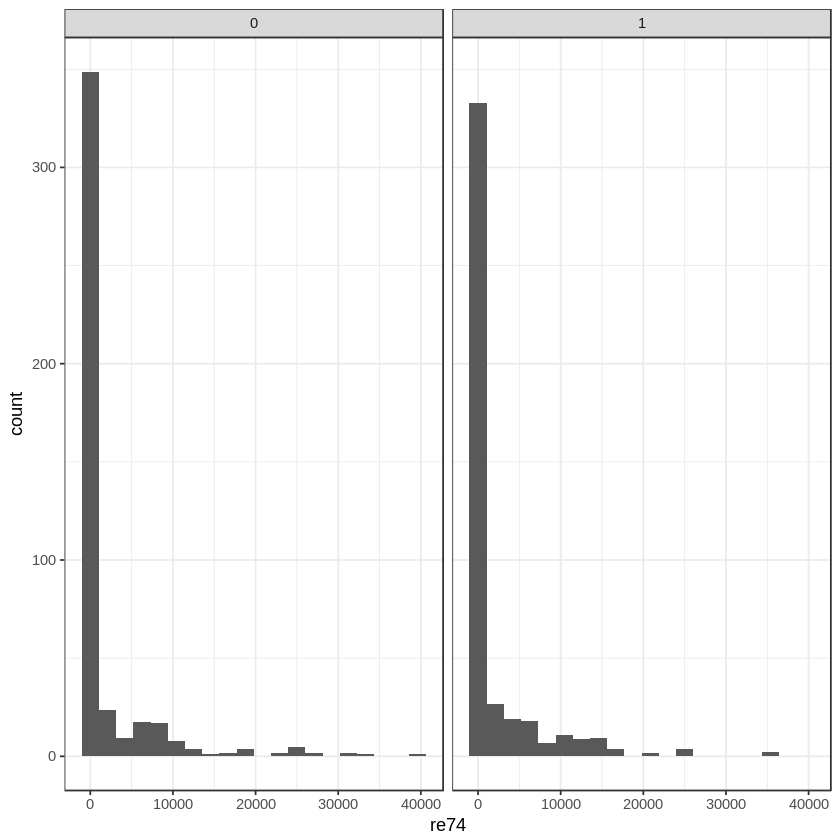

In [8]:
ggplot(data=lalonde,aes(x=re74, weight = ipw.ate))+geom_histogram(bins = 20)+facet_grid(~treat)+theme_bw()

In [56]:
#Double check with hard calculation
(mean_Y1 <- sum(lalonde$ipw.ate * lalonde$re78 * lalonde$treat)/sum(lalonde$ipw.ate * lalonde$treat))
(mean_Y0 <- sum(lalonde$ipw.ate * lalonde$re78 * (1 - lalonde$treat))/sum(lalonde$ipw.ate * (1 - lalonde$treat)))
(mean_Y1 - mean_Y0)

[1] 6191.085

[1] 4549.769

[1] 1641.316

In [5]:
#Propensity Score Regression
ps.reg <- lm(re78 ~ treat + pscore, data=lalonde)
summary(ps.reg)


Call:
lm(formula = re78 ~ treat + pscore, data = lalonde)

Residuals:
   Min     1Q Median     3Q    Max 
 -6771  -4509  -1768   2853  54162 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   3317.1     1388.5   2.389   0.0173 * 
treat         1678.1      645.1   2.601   0.0096 **
pscore        3093.5     3317.0   0.933   0.3515   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6581 on 442 degrees of freedom
Multiple R-squared:  0.01975,	Adjusted R-squared:  0.01532 
F-statistic: 4.453 on 2 and 442 DF,  p-value: 0.01217


In [57]:
#ATT Outcome Analysis
lalonde$ipw.att <- ifelse(lalonde$treat==0, lalonde$pscore/(1-lalonde$pscore), 1)
design.att <- svydesign(ids= ~1, weights= ~ipw.att, dat=lalonde)
mod.ipw.att <- svyglm(re78 ~ treat, design=design.att)
summary(mod.ipw.att)


Call:
svyglm(formula = re78 ~ treat, design = design.att)

Survey design:
svydesign(ids = ~1, weights = ~ipw.att, dat = lalonde)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4542.7      367.7  12.354  < 2e-16 ***
treat         1806.4      684.6   2.639  0.00862 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 45525732)

Number of Fisher Scoring iterations: 2


**QUESTION** What is the ATU (Average Treatment Effect in Untreated)?

In [5]:
#ATU Outcome Analysis
lalonde$ipw.atu <- ifelse(lalonde$treat==0, 1, (1-lalonde$pscore)/lalonde$pscore)
design.atu <- svydesign(ids= ~1, weights= ~ipw.atu, dat=lalonde)
mod.ipw.atu <- svyglm(re78 ~ treat, design=design.atu)
summary(mod.ipw.atu)


Call:
svyglm(formula = re78 ~ treat, design = design.atu)

Survey design:
svydesign(ids = ~1, weights = ~ipw.atu, dat = lalonde)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4554.8      339.8  13.404   <2e-16 ***
treat         1523.2      707.4   2.153   0.0318 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 46210834)

Number of Fisher Scoring iterations: 2


#### How about Stablized Weight?

In [4]:
## the numerator
pa <- mean(lalonde$treat)
## the stablized weight
lalonde$sw.ate <- ifelse(lalonde$treat==1, pa/lalonde$pscore, (1-pa)/(1-lalonde$pscore))
#ATE Outcome Analysis
design.sw <- svydesign(ids= ~1, weights= ~sw.ate, dat=lalonde)
mod.sw.ate <- svyglm(re78 ~ treat, design=design.sw)
summary(mod.sw.ate) # should get same results as the unstablized version


Call:
svyglm(formula = re78 ~ treat, design = design.sw)

Survey design:
svydesign(ids = ~1, weights = ~sw.ate, dat = lalonde)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4549.8      343.2  13.257   <2e-16 ***
treat         1641.3      686.3   2.392   0.0172 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 43204973)

Number of Fisher Scoring iterations: 2
